In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import keras as keras
import keras.layers as layers

from sklearn.model_selection import train_test_split

2024-12-03 01:31:59.128198: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 01:31:59.148292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_map(map):
  cmap = ListedColormap(['green', '#440154', '#FFED23'])
  plt.matshow(map, cmap = cmap)
  plt.show()

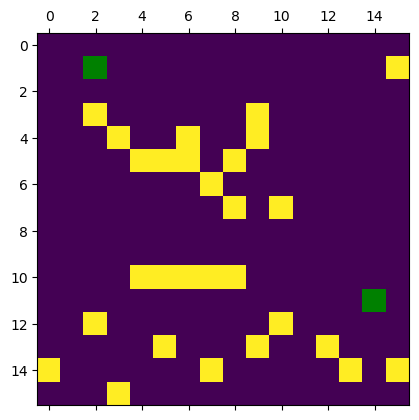

In [3]:
data_x = np.load("data/data_x.npy")
plot_map(data_x[0])

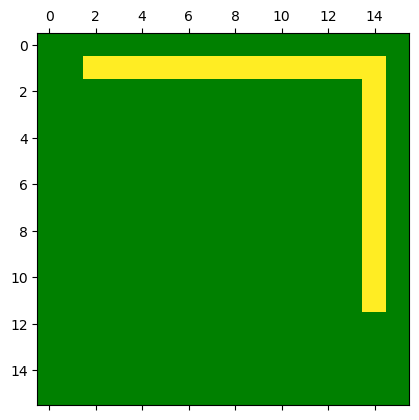

In [4]:
data_y = np.load("data/data_y.npy")
plot_map(data_y[0])

In [5]:
data_x.shape

(99753, 16, 16)

In [6]:
data_y.shape

(99753, 16, 16)

In [7]:
x_train, x_test = train_test_split(data_x, test_size = 0.7, random_state = 0)
y_train, y_test = train_test_split(data_y, test_size = 0.7, random_state = 0)

In [8]:
input_shape = [x_train.shape[1], x_train.shape[2], 1]
input_shape

[16, 16, 1]

In [9]:

from keras.models import Model
from keras.optimizers.schedules import CosineDecayRestarts
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Concatenate, Cropping2D

# Input layer
inputs = Input(shape = input_shape)
mod = 1

# Encoder: Downsampling with skip connections
conv1 = Conv2D(16 * mod, (3, 3), padding="same")(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Activation("relu")(conv1)
conv1 = Conv2D(16 * mod, (3, 3), padding="same")(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation("relu")(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # Downsample

conv2 = Conv2D(32 * mod, (3, 3), padding="same")(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation("relu")(conv2)
conv2 = Conv2D(32 * mod, (3, 3), padding="same")(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation("relu")(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # Downsample

conv3 = Conv2D(64 * mod, (3, 3), padding="same")(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation("relu")(conv3)
conv3 = Conv2D(64 * mod, (3, 3), padding="same")(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation("relu")(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)  # Downsample

conv4 = Conv2D(128 * mod, (3, 3), padding="same")(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation("relu")(conv4)
conv4 = Conv2D(128 * mod, (3, 3), padding="same")(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation("relu")(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)  # Downsample

#-------------------------------------------------------------------

# Bottleneck: Reduced filters to represent the "bottleneck"
bottleneck = Conv2D(16 * mod, (3, 3), padding="same")(pool4)
bottleneck = BatchNormalization()(bottleneck)
bottleneck = Activation("relu")(bottleneck)

#-------------------------------------------------------------------

# Decoder: Upsampling with skip connections
up4 = UpSampling2D(size=(2, 2))(bottleneck)
up4 = Conv2D(128 * mod, (3, 3), padding="same")(up4)
up4 = BatchNormalization()(up4)
up4 = Activation("relu")(up4)

# Cropping to match spatial dimensions before concatenation
crop4 = Cropping2D(((0, 0), (0, 0)))(conv4)
up4 = Concatenate()([up4, crop4])  # Skip connection from cropped conv3
up4 = Conv2D(128 * mod, (3, 3), padding="same")(up4)
up4 = BatchNormalization()(up4)
up4 = Activation("relu")(up4)

up3 = UpSampling2D(size=(2, 2))(up4)
up3 = Conv2D(64 * mod, (3, 3), padding="same")(up3)
up3 = BatchNormalization()(up3)
up3 = Activation("relu")(up3)

# Cropping to match spatial dimensions before concatenation
crop3 = Cropping2D(((0, 0), (0, 0)))(conv3)
up3 = Concatenate()([up3, crop3])  # Skip connection from cropped conv3
up3 = Conv2D(64 * mod, (3, 3), padding="same")(up3)
up3 = BatchNormalization()(up3)
up3 = Activation("relu")(up3)

up2 = UpSampling2D(size=(2, 2))(up3)
up2 = Conv2D(32 * mod, (3, 3), padding="same")(up2)
up2 = BatchNormalization()(up2)
up2 = Activation("relu")(up2)

crop2 = Cropping2D(((0, 0), (0, 0)))(conv2)
up2 = Concatenate()([up2, crop2])  # Skip connection from cropped conv2
up2 = Conv2D(32 * mod, (3, 3), padding="same")(up2)
up2 = BatchNormalization()(up2)
up2 = Activation("relu")(up2)

up1 = UpSampling2D(size=(2, 2))(up2)
up1 = Conv2D(16 * mod, (3, 3), padding="same")(up1)
up1 = BatchNormalization()(up1)
up1 = Activation("relu")(up1)

crop1 = Cropping2D(((0, 0), (0, 0)))(conv1)
up1 = Concatenate()([up1, crop1])  # Skip connection from cropped conv1
up1 = Conv2D(16 * mod, (3, 3), padding="same")(up1)
up1 = BatchNormalization()(up1)
up1 = Activation("relu")(up1)

# Output layer
outputs = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(up1)  # Final prediction map

# Define the cosine annealing with warm restarts learning rate schedule
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=0.001,  
    first_decay_steps=1000,       
    t_mul=2.0,                    
    m_mul=1.0,                    
    alpha=0.0                     
)

# Model
model = Model(inputs, outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="mean_absolute_error")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 16)  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 32)  │      4,640 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 32)  │      9,248 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 32)  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 4, 64)  │     18,496 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 4, 4, 64)  │          0 │ batch_normalizat

 Total params: 822,961 (3.14 MB)

 Trainable params: 821,009 (3.13 MB)

 Non-trainable params: 1,952 (7.62 KB)

In [10]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

savename = "models/16x16_stable"

# Early stopping monitors validation loss
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Model checkpoint saves the best weights based on validation loss
mc = ModelCheckpoint(
    filepath=savename + ".weights.h5",  # Changed to .weights.h5
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
    save_weights_only=True,  # Save only weights
)


In [11]:
num_epochs = 100
hist = model.fit(x_train,
                 y_train,
                 epochs = num_epochs,
                 batch_size = 32,
                 validation_data = (x_test, y_test),
                 callbacks = [es, mc])

Epoch 1/100
  4/936 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - loss: 0.5035  

2024-12-03 01:32:05.932546: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1614
Epoch 1: val_loss improved from inf to 0.05242, saving model to models/16x16_stable.weights.h5
936/936 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - loss: 0.1614 - val_loss: 0.0524
Epoch 2/100
933/936 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0401
Epoch 2: val_loss improved from 0.05242 to 0.01905, saving model to models/16x16_stable.weights.h5
936/936 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 0.0401 - val_loss: 0.0190
Epoch 3/100
935/936 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0164
Epoch 3: val_loss improved from 0.01905 to 0.01417, saving model to models/16x16_stable.weights.h5
936/936 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 0.0164 - val_loss: 0.0142
Epoch 4/100
935/936 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0138
Epoch 4: val_loss improved from 0.01417 to 0.01253, saving model to models/16x16_stable.weights.h5
936/936 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - loss: 0.0138 - val_loss: 0.0125
Epoch 5/100
934/936 ━━━━━━━━━━━━━━━━

In [22]:
plt.plot(hist.history['loss'], label = 'Training')
plt.plot(hist.history['val_loss'], label = 'Validation')

plt.legend(loc = 'best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.grid(True)

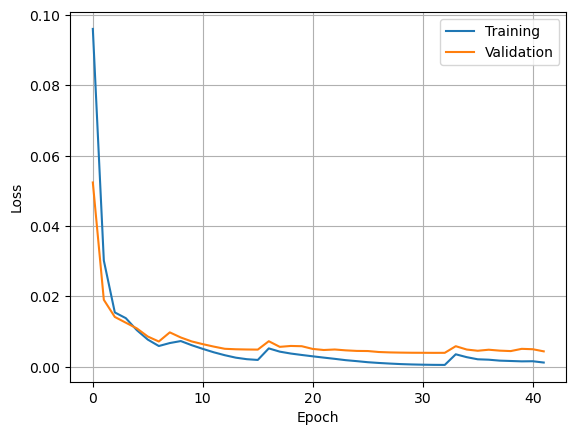

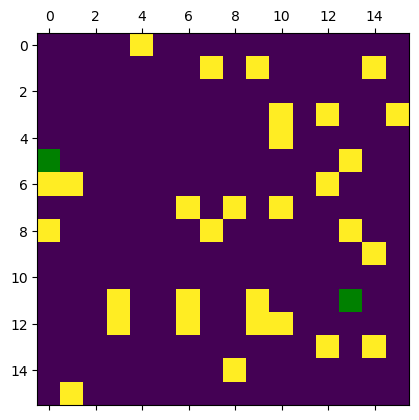

In [23]:
plot_map(x_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


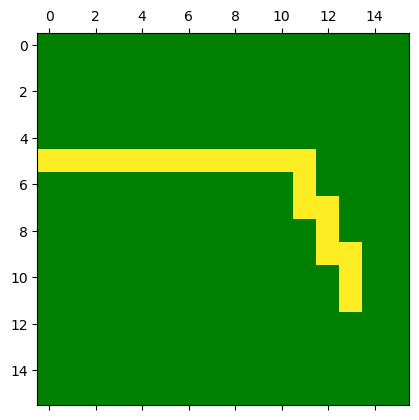

In [14]:
plot_map(model.predict(x_test[0:1])[0, :, :, 0])

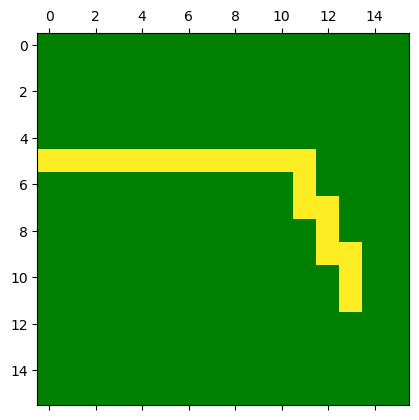

In [15]:
plot_map(y_test[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


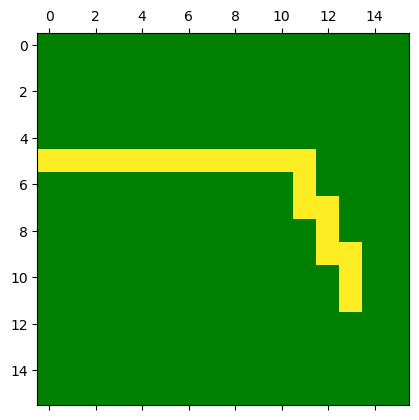

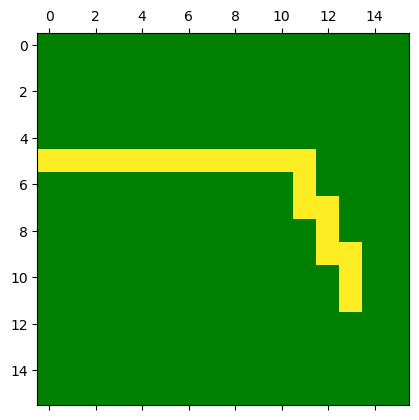

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


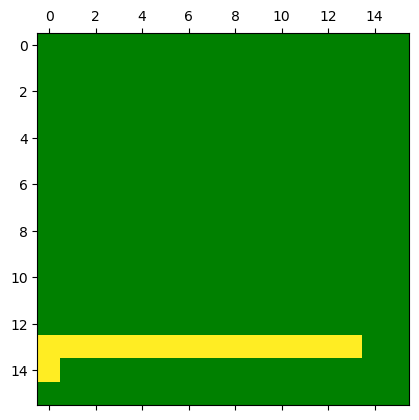

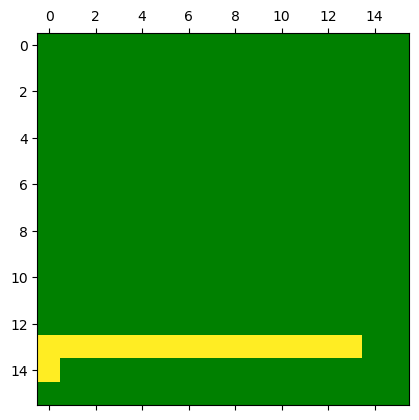

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


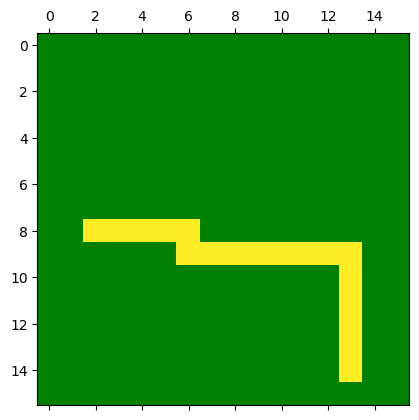

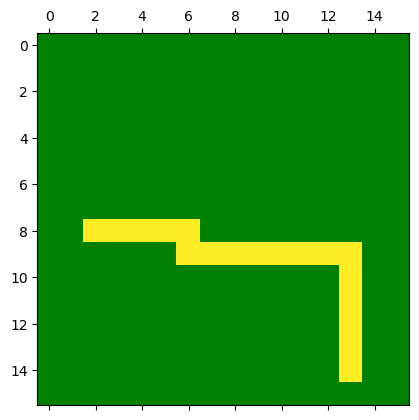

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


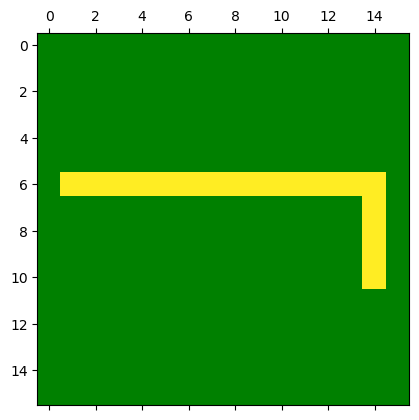

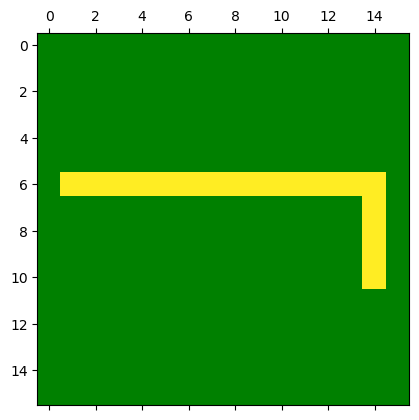

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


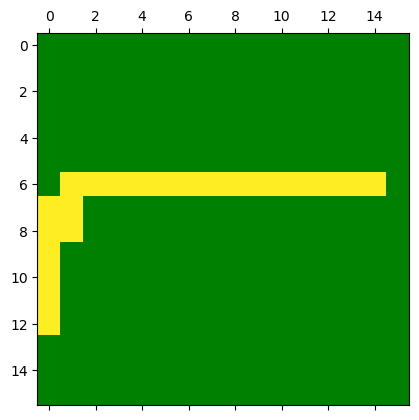

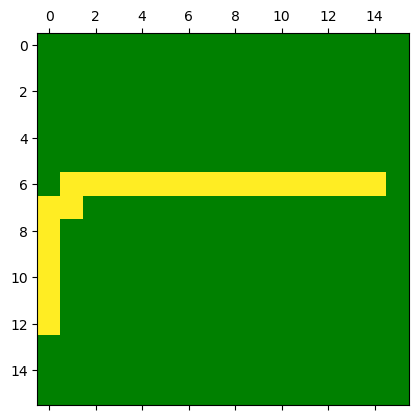

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


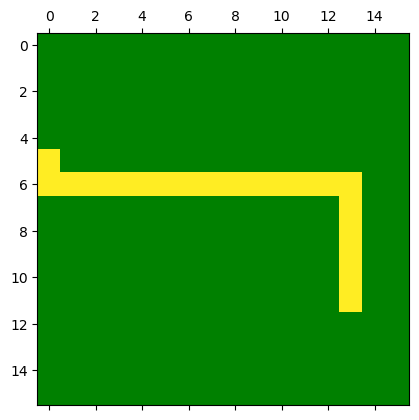

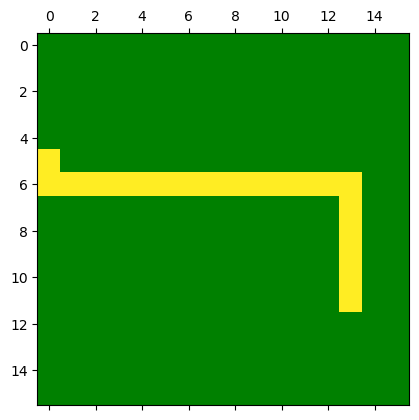

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


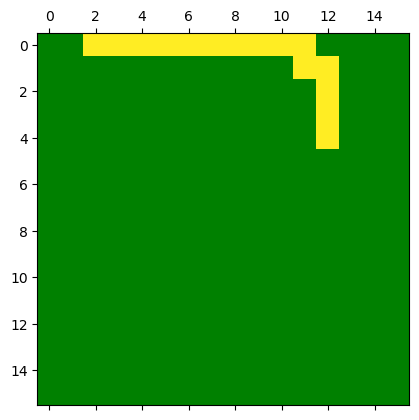

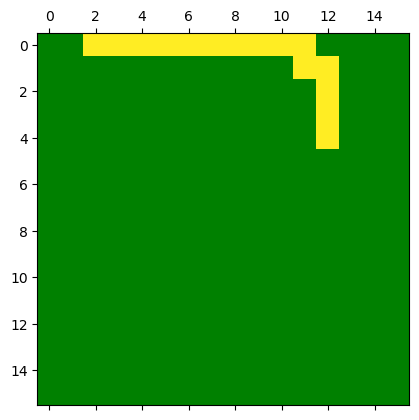

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


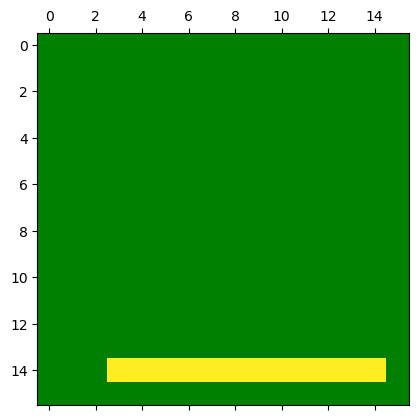

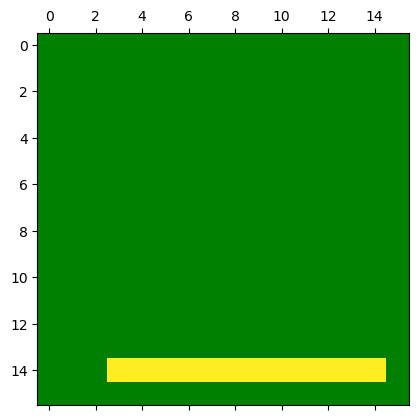

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


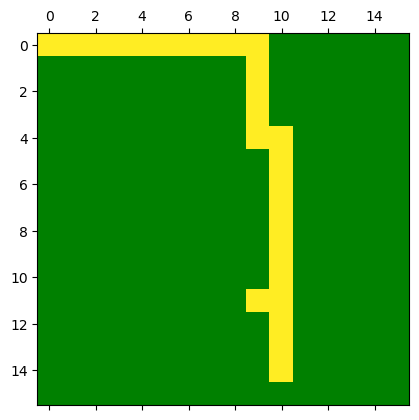

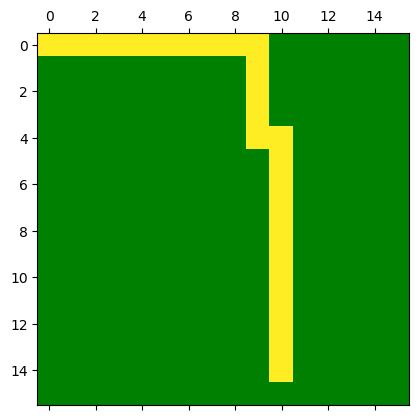

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


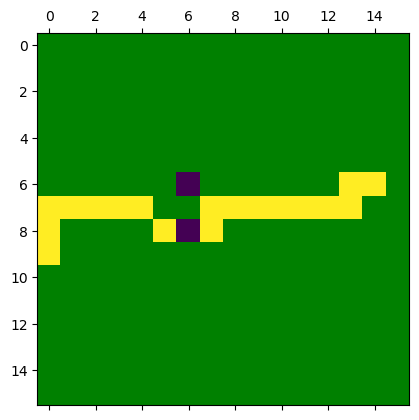

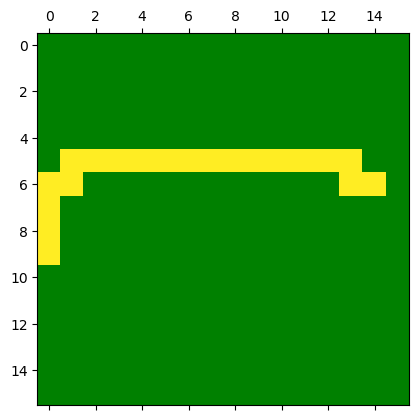

In [16]:
for i in range(0, 10):
    plot_map(model.predict(x_test[i: i+1])[0, :, :, 0])
    plot_map(y_test[i])